In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd

MainProcess


In [2]:
# Prepare datasets
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', fls.result_dir + '/many_abbr_res/')

In [3]:
# Read results from vast.ai
files = glob.glob(fls.result_dir + '/many_abbr_res/' + '*.pickle')
dicts = []
for f in files:    
    data = fls.dill_load(f)    
    d = data.modifier_values
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value
    d['cv_score'] = fls.score_competition_metric(data.inferred_test_data, data.test_data)
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))
    d['k_score']= np.nan
    dicts.append(d)
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

In [4]:
# Load Kaggle results
p_kaggle_results = pd.read_csv(fls.code_dir + '../kaggle_results.csv')
print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

    Unnamed: 0                             git_commit_id  seed  k_score
0            0  a103863a276b4f124f36587b568e788ff5d70412     0    0.276
1            3  a103863a276b4f124f36587b568e788ff5d70412     1    0.201
2            4  a103863a276b4f124f36587b568e788ff5d70412     2      NaN
3            5  a103863a276b4f124f36587b568e788ff5d70412     3      NaN
4            6  a103863a276b4f124f36587b568e788ff5d70412     4      NaN
5            7  a103863a276b4f124f36587b568e788ff5d70412     5      NaN
6            8  a103863a276b4f124f36587b568e788ff5d70412     6      NaN
7            9  a103863a276b4f124f36587b568e788ff5d70412     7      NaN
8           10  a103863a276b4f124f36587b568e788ff5d70412     8      NaN
9           11  a103863a276b4f124f36587b568e788ff5d70412     9      NaN
10           1  a103863a276b4f124f36587b568e788ff5d70412    10      NaN
11           2  a103863a276b4f124f36587b568e788ff5d70412    11      NaN


In [5]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p[['git_commit_id', 'seed', 'k_score']])
p_kaggle_cache.to_csv(fls.code_dir + '../kaggle_results.csv')

In [6]:
p.to_csv(fls.code_dir + '../results.csv')
p

,seed,scale_percentile_value,img_size,n_epochs,model_name,use_pretrained_weights,box_size,trust,fix_norm_bug,weight_decay,...,aba,ycw,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_ycw,cv_score_aba,cv_score_mba,k_score
0,0,3.547847,512,41,yolov8m,False,16,1,True,0.000607,...,False,True,a103863a276b4f124f36587b568e788ff5d70412,False,0.651396,0.866873,0.698925,0.384615,0.670732,0.276
3,1,3.047286,576,96,yolov8m,True,18,1,False,0.000828,...,True,True,a103863a276b4f124f36587b568e788ff5d70412,False,0.357417,0.563140,0.121951,0.145631,0.397083,0.201
4,2,2.046449,320,43,yolov8l,False,29,2,True,0.000188,...,True,False,a103863a276b4f124f36587b568e788ff5d70412,False,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
5,3,1.342597,384,38,yolov8m,True,28,0,False,0.000479,...,True,False,a103863a276b4f124f36587b568e788ff5d70412,False,0.057661,0.000000,0.000000,0.000000,0.120275,NaN
6,4,4.772224,640,60,yolo11m,False,31,2,False,0.000802,...,False,True,a103863a276b4f124f36587b568e788ff5d70412,False,0.020747,0.058824,0.121951,0.000000,0.000000,NaN
7,5,4.220012,320,84,yolov8l,True,24,5,False,0.000408,...,True,False,a103863a276b4f124f36587b568e788ff5d70412,False,0.256917,0.078125,0.000000,0.000000,0.484897,NaN
8,6,3.152657,512,47,yolo11m,True,21,2,True,0.000674,...,True,False,a103863a276b4f124f36587b568e788ff5d70412,False,0.765027,0.680473,0.698925,0.821727,0.786350,NaN
9,7,3.500382,576,91,yolov8l,True,28,0,True,0.000005,...,True,False,a103863a276b4f124f36587b568e788ff5d70412,False,0.222399,0.114943,0.505618,0.522388,0.052265,NaN
10,8,2.573243,640,80,yolov8l,True,17,3,False,0.000134,...,True,True,a103863a276b4f124f36587b568e788ff5d70412,False,0.270164,0.340502,0.604396,0.370370,0.128645,NaN
11,9,4.480997,640,42,yolov8m,True,25,3,True,0.000860,...,True,True,a103863a276b4f124f36587b568e788ff5d70412,False,0.750346,0.855457,0.833333,0.664740,0.729323,NaN


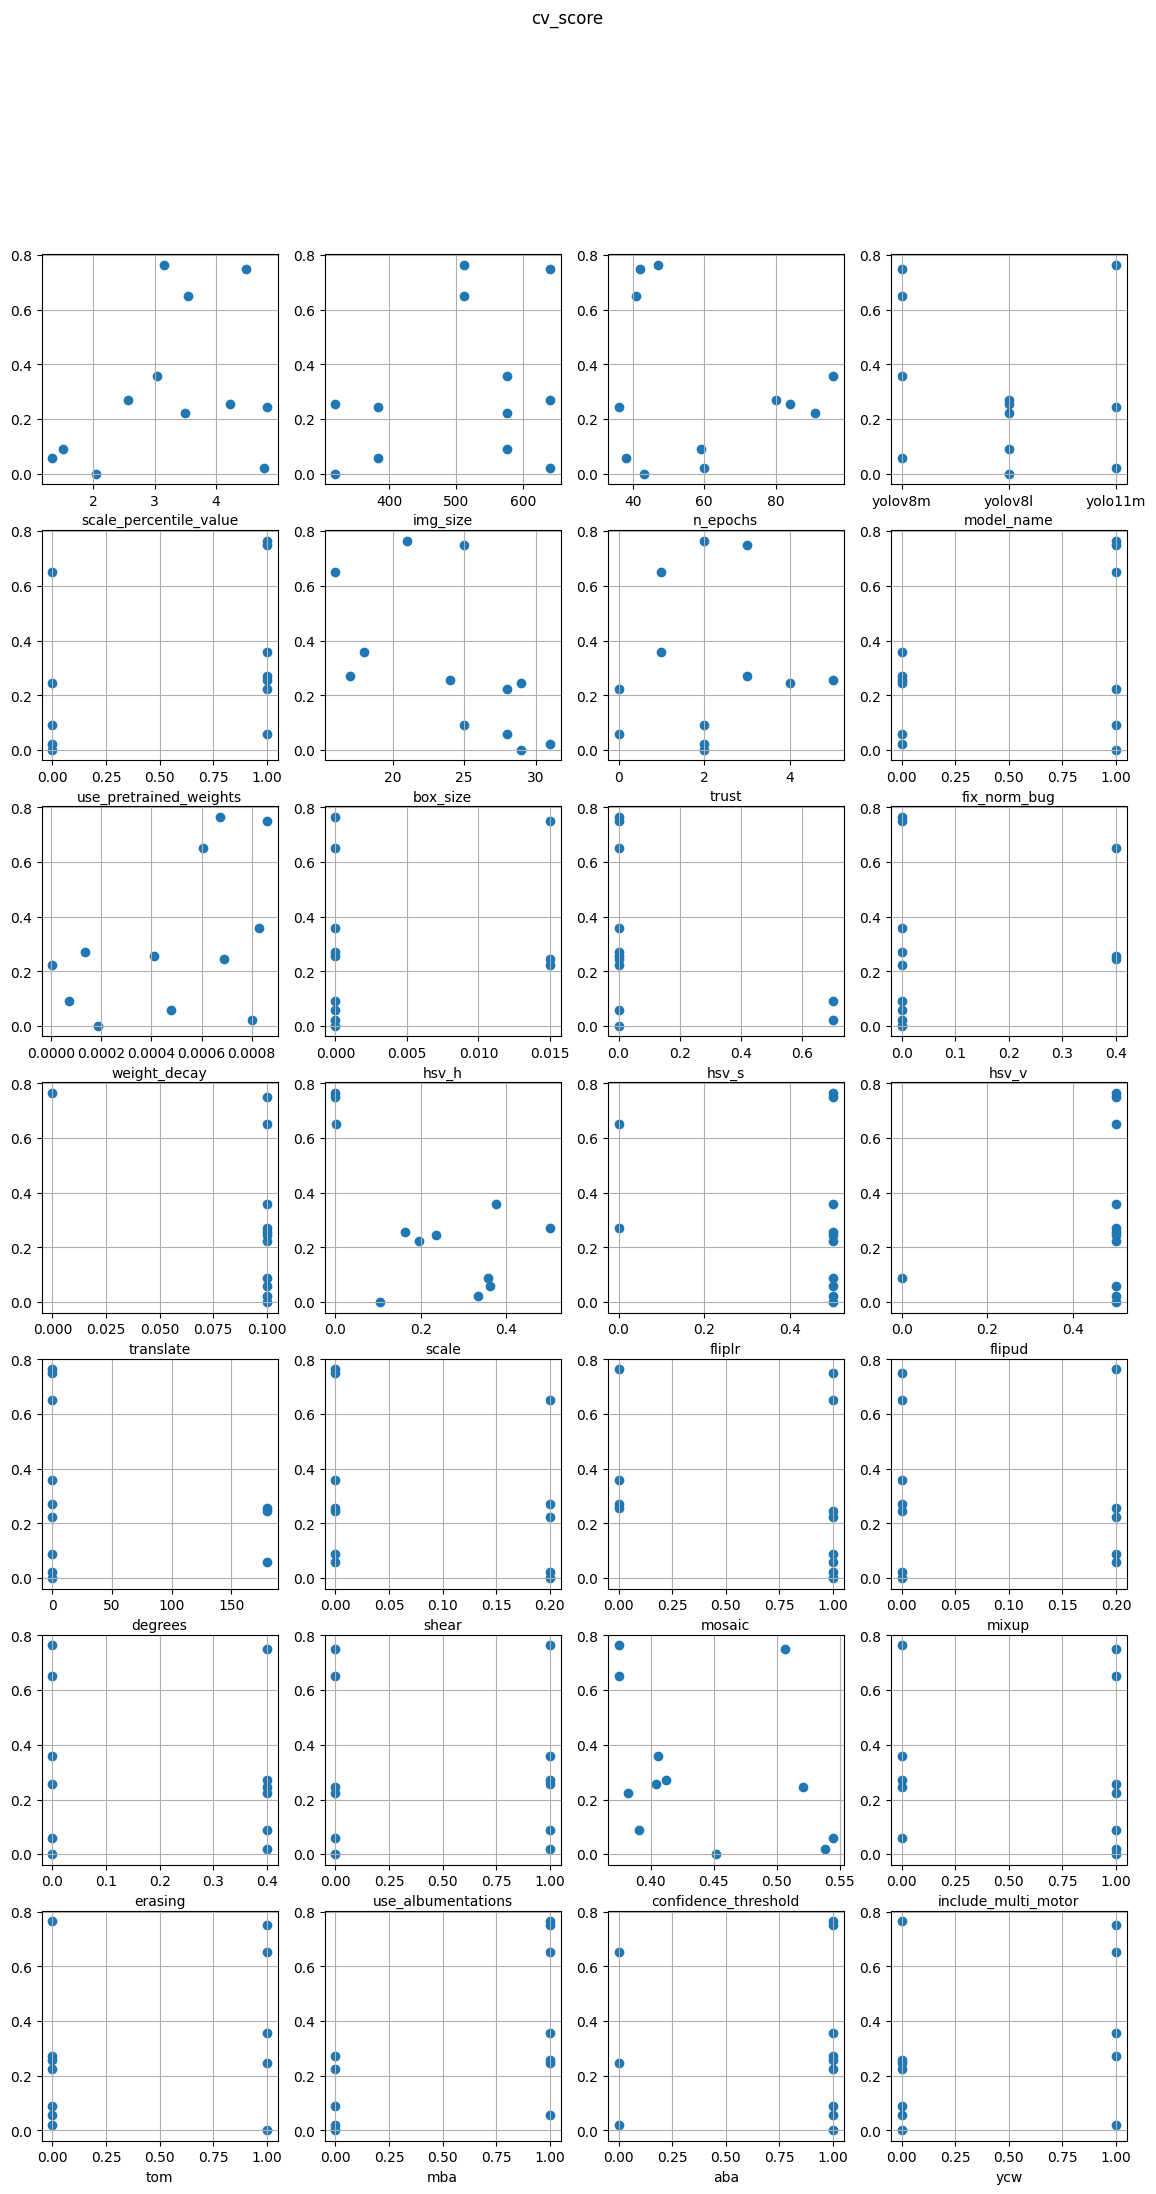

In [8]:
to_plot = p.columns.to_list()[1:-8]
ncols = 4
nrows = len(to_plot)//ncols
for y_val in p.columns.to_list()[-6:]:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14/ncols*nrows))
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)
        plt.xlabel(d)
        plt.ylabel('')
        plt.grid(True)
        plt.scatter(p[d], p[y_val])
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)